In [1]:
import sys
import os

src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    

In [2]:
from models.training import entrenar_modelos

In [3]:
# IMPORTAMOS funciones
from data.processing import procesar_contaminante, procesar_meteorologia, unir_datasets

# CARGAMOS LOS DATOS CRUDOS
import pandas as pd
df_pm10 = pd.read_csv('../data/raw/pm 10 coyhaique (extended).csv', sep=';', encoding='latin1', engine='python')
df_pm25 = pd.read_csv('../data/raw/pm 2.5 coyhaique.csv', sep=';')
df_co = pd.read_csv('../data/raw/CO coyhaique.csv', sep=';')
df_so2 = pd.read_csv('../data/raw/SO2 coyahique.csv', sep=';')
df_meteo = pd.read_csv('../data/raw/export (extended).csv')
df_umbrales = pd.read_csv('../data/raw/umbrales_pm10.csv', sep=';')

# PROCESAMOS Y UNIMOS
df_pm10 = procesar_contaminante(df_pm10, 'PM10')
df_pm25 = procesar_contaminante(df_pm25, 'PM2.5')
df_co = procesar_contaminante(df_co, 'CO', decimal_coma=True)
df_so2 = procesar_contaminante(df_so2, 'SO2')
df_meteo = procesar_meteorologia(df_meteo)
df_total = unir_datasets(df_pm10, df_pm25, df_co, df_so2, df_meteo, df_umbrales)

Accuracy Árbol de Decisión: 1.0
Accuracy Random Forest: 1.0


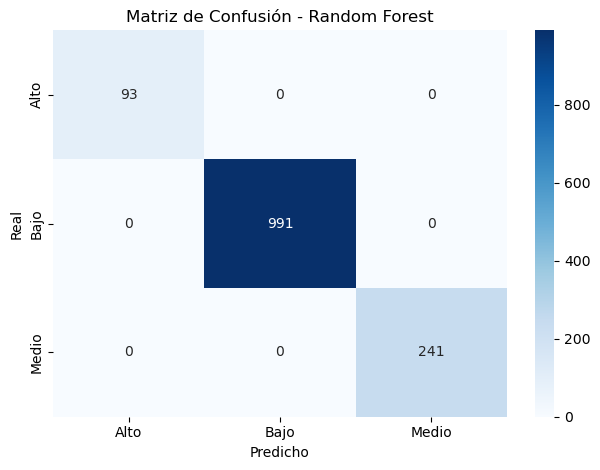

In [4]:

# ENTRENAR LOS MODELOS
dt_model, rf_model, resultados = entrenar_modelos(df_total)

# VER RESULTADOS
print("Accuracy Árbol de Decisión:", resultados['accuracy_dt'])
print("Accuracy Random Forest:", resultados['accuracy_rf'])

# Matriz de confusión y F1 por clase
import seaborn as sns
import matplotlib.pyplot as plt

conf = resultados['confusion_rf']
etiquetas = resultados['label_encoder'].classes_

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import classification_report, f1_score

y_true = resultados['y_test']
y_pred = resultados['y_pred_rf']

print(classification_report(y_true, y_pred, target_names=resultados['label_encoder'].classes_))
print("F1-score (ponderado):", f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00        93
        Bajo       1.00      1.00      1.00       991
       Medio       1.00      1.00      1.00       241

    accuracy                           1.00      1325
   macro avg       1.00      1.00      1.00      1325
weighted avg       1.00      1.00      1.00      1325

F1-score (ponderado): 1.0


In [ ]:
# 🔁 Forzar recarga del módulo
import importlib
import models.training
importlib.reload(models.training)

In [ ]:
from models.training import entrenar_modelos
dt_model, rf_model, resultados = entrenar_modelos(df_total)


In [ ]:
import joblib

# Guardar modelo entrenado
joblib.dump(rf_model, '../models/random_forest_model.pkl')
joblib.dump(dt_model, '../models/decision_tree_model.pkl')

In [ ]:
import json

metricas = {
    "accuracy_dt": resultados['accuracy_dt'],
    "accuracy_rf": resultados['accuracy_rf'],
    "f1_score_rf": resultados['f1_rf']
}

with open('../reports/metricas_modelo.json', 'w') as f:
    json.dump(metricas, f, indent=4)